## Cómputo de la función de transferencia y desfasaje de un filtro RC

En este notebook levantamos los datos de un barrido en frecuencia de un filtro RC. 

Para cada frecuencia, calculamos la amplitud pico a pico de la señal de entrada y la de salida. 

Calculamos la diferencia de fase haciendo un ajuste armónico de la señal de entrada y de salida.

In [1]:
import numpy as np
import matplotlib.pyplot as plt
import matplotlib
import pandas as pd
from scipy.optimize import curve_fit

matplotlib.rcParams['mathtext.fontset'] = 'cm'
matplotlib.rcParams['font.family'] = 'STIXGeneral'

In [2]:
#Levantamos los datos
save_folder = 'path/'

#Levantar los datos
df = pd.read_csv(save_folder+"data_test.csv", index_col=["Frecuencias"])

df.head()

,Tiempo,VoltajeCH1,VoltajeCH2
Frecuencias,,,
0.1,0.000000,0.000000,-0.001000
0.1,0.010001,0.006284,0.005284
0.1,0.020002,0.012567,0.011567
0.1,0.030003,0.018850,0.017850
0.1,0.040004,0.025133,0.024133


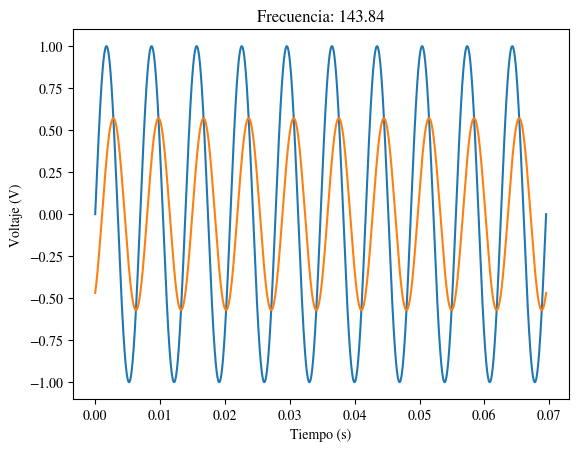

In [3]:
#buscamos las frecuencias del barrido
frecuencias = np.unique(df.index) 

#graficamos uno de los datos
freq = frecuencias[10]

tiempo = df.loc[freq]["Tiempo"].values
vch1 = df.loc[freq]["VoltajeCH1"].values
vch2 = df.loc[freq]["VoltajeCH2"].values

plt.plot(tiempo, vch1, label="voltaje ch1")
plt.plot(tiempo, vch2, label="voltaje ch2")
plt.xlabel("Tiempo (s)")
plt.ylabel("Voltaje (V)")
plt.title("Frecuencia: "+str(np.round(freq,2)))
plt.show()

**Cálculo de la amplitud en función de la frecuencia**

In [4]:
amplitud_ch1 = []
amplitud_ch2 = []

for freq in frecuencias:
    vch1 = df.loc[freq]["VoltajeCH1"].values
    vch2 = df.loc[freq]["VoltajeCH2"].values

    amplitud_ch1.append(np.max(vch1)-np.min(vch1))
    amplitud_ch2.append(np.max(vch2)-np.min(vch2))

amplitud_ch1 = np.array(amplitud_ch1)
amplitud_ch2 = np.array(amplitud_ch2)

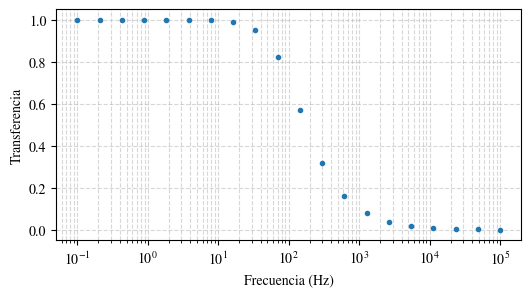

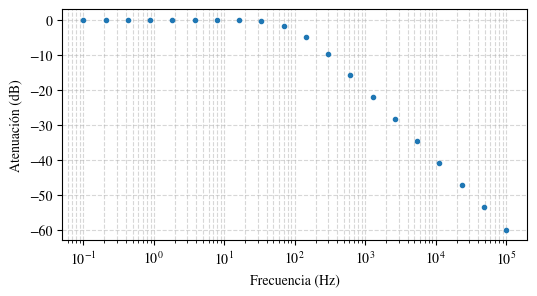

In [5]:
#Graficamos
plt.figure(figsize=(6, 3))
plt.plot(frecuencias, amplitud_ch2 / amplitud_ch1, marker='.', linestyle='')
plt.xscale('log')
plt.grid(visible = True, which = 'both', linestyle='dashed', alpha=.5)
plt.ylabel("Transferencia")
plt.xlabel(r"Frecuencia (Hz)")
plt.show()

#Atenuacion en decibeles
atenuacion = 20 * np.log10(amplitud_ch2 / amplitud_ch1)

plt.figure(figsize=(6, 3))
plt.plot(frecuencias, atenuacion, marker='.', linestyle='')
plt.xscale('log')
plt.grid(visible = True, which = 'both', linestyle='dashed', alpha=.5)
plt.ylabel("Atenuación (dB)")
plt.xlabel(r"Frecuencia (Hz)")
plt.show()


**Cálculo de la diferencia de fase**

Lo hacemos ajustando por una función armónica. No tengo en cuenta los errores (agregarlo).

Empecemos poniendo a punto el método con una medición. Después hacemos un barrido para todas las mediciones del barrido.


Resultados del ajuste Vin:
Parámetro 0: 1.0 ± 2.6295568830589993e-16
Parámetro 1: 143.8449888287663 ± 2.0831867394877465e-15
Parámetro 2: 4.4635875885737124e-14 ± 5.254309656528481e-16
Resultados del ajuste Vout:
Parámetro 0: 0.5708102801766461 ± 1.5029496105448602e-16
Parámetro 1: 143.8449888287663 ± 2.0893202676870292e-15
Parámetro 2: -0.9633039652775078 ± 5.209406991190299e-16


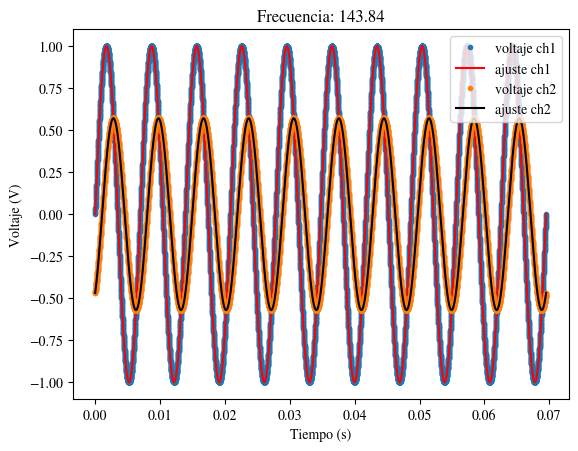

In [6]:
#Calculamos el retraso temporal del canal 2

#graficamos uno de los datos
freq = frecuencias[10]

tiempo = df.loc[freq]["Tiempo"].values
vch1 = df.loc[freq]["VoltajeCH1"].values
vch2 = df.loc[freq]["VoltajeCH2"].values

#Ajustamos
def f(tiempo, A, freq, fase):
    return A * np.sin( 2 * np.pi * freq * tiempo + fase )

#Ajustamos la señal de entrada
init_guess = [1, freq, 0] 
popt, pcov = curve_fit(f, tiempo, vch1, p0 = init_guess) # popt son los parámetros del ajuste, pcov la "matriz de covarianza"
perr = np.sqrt(np.diag(pcov)) # los errores de los parámetros del ajuste son la raíz cuadrada de la diagonal de la matriz de covarianza

print('Resultados del ajuste Vin:')
for i in range(len(popt)):
  print('Parámetro ' + str(i) + ': ' + str(popt[i]) + " \u00B1 " + str(perr[i]))

# #Ajustamos la señal de salida
init_guess_2 = [1, freq, 0] 
popt_2, pcov_2 = curve_fit(f, tiempo, vch2, p0 = init_guess) # popt son los parámetros del ajuste, pcov la "matriz de covarianza"
perr_2 = np.sqrt(np.diag(pcov_2)) # los errores de los parámetros del ajuste son la raíz cuadrada de la diagonal de la matriz de covarianza

print('Resultados del ajuste Vout:')
for i in range(len(popt_2)):
  print('Parámetro ' + str(i) + ': ' + str(popt_2[i]) + " \u00B1 " + str(perr_2[i]))


plt.plot(tiempo, vch1, '.', label="voltaje ch1")
plt.plot(tiempo, f(tiempo, *popt), 'r', label="ajuste ch1")

plt.plot(tiempo, vch2, '.', label="voltaje ch2")
plt.plot(tiempo, f(tiempo, *popt_2), 'k', label="ajuste ch2")
plt.legend(loc=1)
plt.xlabel("Tiempo (s)")
plt.ylabel("Voltaje (V)")
plt.title("Frecuencia: "+str(np.round(freq,2)))
plt.show()

In [7]:
#Teniendo el ajuste, podemos calcular la fase:
dif_fase = popt_2[2] - popt[2]  

print("La diferencia de fase en radianes es: ", dif_fase)
print("La diferencia de fase en grados es: ", 180 * dif_fase / np.pi)

La diferencia de fase en radianes es:  -0.9633039652775525
La diferencia de fase en grados es:  -55.193251598620556


**Calculamos la diferencia de fase para todas las mediciones**

In [8]:
dif_fase = []

for freq in frecuencias:
    tiempo = df.loc[freq]["Tiempo"].values
    vch1 = df.loc[freq]["VoltajeCH1"].values
    vch2 = df.loc[freq]["VoltajeCH2"].values

    #primer ajuste
    init_guess = [1, freq, 0] 
    popt, pcov = curve_fit(f, tiempo, vch1, p0 = init_guess) # popt son los parámetros del ajuste, pcov la "matriz de covarianza"

    #segundo ajuste
    init_guess = [1, freq, 0] 
    popt_2, pcov_2 = curve_fit(f, tiempo, vch2, p0 = init_guess) # popt son los parámetros del ajuste, pcov la "matriz de covarianza"

    #guardamos el resultado
    dif_fase.append( popt_2[2] - popt[2]   )

dif_fase = np.array(dif_fase)

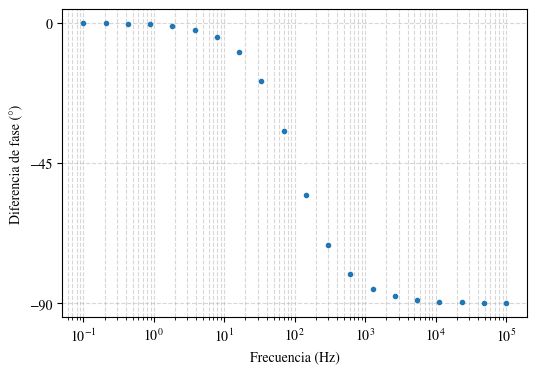

In [9]:
#Graficamos
plt.figure(figsize=(6,4))
plt.plot(frecuencias, 180 * dif_fase / (np.pi), '.')
plt.ylabel("Diferencia de fase (°)")
plt.xlabel("Frecuencia (Hz)")
plt.yticks([0, -45,-90])
plt.grid(visible = True, which = 'both', linestyle='dashed', alpha=.5)
plt.xscale('log')
plt.show()